In [1]:
import requests
import pandas as pd
import numpy as np
import nba_py as nba
from nba_py import game, team, player, constants
import inspect
from tqdm import tqdm
from time import sleep
from itertools import chain
from pathlib import Path
from datetime import date, timedelta, datetime
from functools import reduce
from sklearn import preprocessing

import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
sns.__version__


'0.9.0'

In [3]:
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / 'nba_py_data'
DATA_DIR.mkdir(exist_ok=True, parents=True)

## 1. Pull data

In [3]:
player_stats_3_seasons = pd.read_csv(DATA_DIR / 'player_stats_15-18-v4.csv')
player_stats_3_seasons = player_stats_3_seasons.iloc[:, 1:]

player_stats_3_seasons.shape
player_stats_3_seasons.head()

(93967, 50)

SEASON_YEAR   GAME_DATE   GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  \
0     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
1     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
2     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
3     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
4     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   

   PLAYER_ID       PLAYER_NAME START_POSITION COMMENT        MIN  FGM   FGA  \
0     204060        Joe Ingles              F     NaN  27.633333  2.0   7.0   
1     202324    Derrick Favors              F     NaN  26.850000  4.0   8.0   
2     203497       Rudy Gobert              C     NaN  31.966667  5.0  11.0   
3    1628378  Donovan Mitchell              G     NaN  33.566667  6.0  23.0   
4     201937       Ricky Rubio              G     NaN  23.933333  5.0  12.0   

   FG_PCT  FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB   REB  AST  STL  \
0   0.286   1.0   2.0    0.500  0.0  0.0   0.000   1.0   3.0   4.0  1.0  0.0   
1   0.500   0.0   1.0    0.000  2.0  2.0   1.000   3.0   3.0   6.0  0.0  0.0   
2   0.455   0.0   0.0    0.000  3.0  4.0   0.750   6.0   7.0  13.0  1.0  0.0   
3   0.261   1.0   8.0    0.125  4.0  6.0   0.667   1.0   5.0   6.0  5.0  2.0   
4   0.417   1.0   1.0    1.000  6.0  6.0   1.000   0.0   5.0   5.0  5.0  1.0   

   BLK   TO   PF   PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
0  0.0  3.0  1.0   5.0        -3.0          94.6        98.3         103.1   
1  4.0  0.0  0.0  10.0       -15.0          78.9        75.9         105.7   
2  1.0  2.0  3.0  13.0        -6.0          90.5        97.1         105.4   
3  0.0  2.0  2.0  17.0        -2.0          96.0       102.9         102.2   
4  0.0  4.0  5.0  17.0       -10.0          86.3        88.5         106.6   

   DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
0       103.4          -8.5        -5.2    0.053     0.33        9.1   
1       107.7         -26.8       -31.8    0.000     0.00        0.0   
2       107.4         -14.9       -10.3    0.053     0.50        6.3   
3       104.3          -6.2        -1.4    0.263     2.50       15.6   
4       109.8         -20.3       -21.3    0.455     1.25       21.7   

   OREB_PCT  DREB_PCT  REB_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  USG_PCT  \
0     0.031     0.115    0.069        27.3    0.357   0.357    0.147   
1     0.091     0.111    0.100         0.0    0.500   0.563    0.138   
2     0.143     0.212    0.173        12.5    0.455   0.509    0.181   
3     0.024     0.147    0.080         6.3    0.283   0.332    0.321   
4     0.000     0.192    0.089        17.4    0.458   0.581    0.290   

   E_USG_PCT  E_PACE    PACE    PIE  
0      0.146  102.90  100.75  0.005  
1      0.148   93.82   94.75  0.145  
2      0.178  107.60  102.86  0.105  
3      0.318  103.90   99.38  0.053  
4      0.294  106.09  103.29  0.140

In [4]:
#check distinct players per team
player_count_grp = player_stats_3_seasons.groupby(by = ['SEASON_YEAR', 'GAME_ID', 'TEAM_ID']).PLAYER_ID.nunique()

player_count_grp.max()
player_count_grp.min()
# player_count_df

15

10

## 2. Check data, evaluate nulls

### 2.1 exploration

In [16]:
# test to find overall min/max active players
comments_test = player_stats_3_seasons.loc[(player_stats_3_seasons['COMMENT'].isna())]
test_grp = comments_test.groupby(by = ['SEASON_YEAR', 'GAME_ID', 'TEAM_ID']).PLAYER_ID.nunique()

test_grp.max()
test_grp.min()
comments_test.shape
comments_test.isnull().sum()

# max active players (13) matches the nba guidelines that a max of 12 or 13 players may be fielded per game
# min active players (7), so capping the data at 7 players per team is a reasonable first pass
# overall the data looks clean, only the three cols for rebound % from advanced box stats need to be checked

13

7

(78324, 51)

SEASON_YEAR              0
GAME_DATE                0
GAME_ID                  0
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_CITY                0
PLAYER_ID                0
PLAYER_NAME              0
START_POSITION       41424
COMMENT              78324
MIN                      0
FGM                      0
FGA                      0
FG_PCT                   0
FG3M                     0
FG3A                     0
FG3_PCT                  0
FTM                      0
FTA                      0
FT_PCT                   0
OREB                     0
DREB                     0
REB                      0
AST                      0
STL                      0
BLK                      0
TO                       0
PF                       0
PTS                      0
PLUS_MINUS               0
E_OFF_RATING             0
OFF_RATING               0
E_DEF_RATING             0
DEF_RATING               0
E_NET_RATING             0
NET_RATING               0
AST_PCT                  0
A

In [38]:
# percent of missing "*reb_pct" 
print('Percent of missing "OREB_PCT" records is %.2f%%' %((comments_test['OREB_PCT'].isnull().sum()/comments_test.shape[0])*100))
print('Percent of missing "DREB_PCT" records is %.2f%%' %((comments_test['DREB_PCT'].isnull().sum()/comments_test.shape[0])*100))
print('Percent of missing "REB_PCT" records is %.2f%%' %((comments_test['REB_PCT'].isnull().sum()/comments_test.shape[0])*100))


Percent of missing "OREB_PCT" records is 35.65%
Percent of missing "DREB_PCT" records is 35.62%
Percent of missing "REB_PCT" records is 49.17%


In [30]:
# create new df for rows where reb_pct is null

reb_null_df = comments_test.loc[(comments_test['REB_PCT'].isna())]
reb_null_df.drop(reb_null_df.columns[42:51], axis = 1, inplace = True)
reb_null_df.drop(reb_null_df.columns[23:39], axis = 1, inplace = True)
reb_null_df.drop(reb_null_df.columns[11:20], axis = 1, inplace = True)
reb_null_df.shape
reb_null_df.head(50)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(38511, 17)

SEASON_YEAR   GAME_DATE   GAME_ID     TEAM_ID TEAM_ABBREVIATION  \
30983     2016-17  2017-04-12  21601220  1610612755               PHI   
30984     2016-17  2017-04-12  21601220  1610612755               PHI   
30987     2016-17  2017-04-12  21601220  1610612755               PHI   
30995     2016-17  2017-04-12  21601220  1610612752               NYK   
30999     2016-17  2017-04-12  21601220  1610612752               NYK   
31001     2016-17  2017-04-12  21601220  1610612752               NYK   
31005     2016-17  2017-04-12  21601228  1610612758               SAC   
31006     2016-17  2017-04-12  21601228  1610612758               SAC   
31007     2016-17  2017-04-12  21601228  1610612758               SAC   
31008     2016-17  2017-04-12  21601228  1610612758               SAC   
31009     2016-17  2017-04-12  21601228  1610612758               SAC   
31010     2016-17  2017-04-12  21601228  1610612758               SAC   
31011     2016-17  2017-04-12  21601228  1610612758               SAC   
31017     2016-17  2017-04-12  21601228  1610612746               LAC   
31018     2016-17  2017-04-12  21601228  1610612746               LAC   
31019     2016-17  2017-04-12  21601228  1610612746               LAC   
31020     2016-17  2017-04-12  21601228  1610612746               LAC   
31021     2016-17  2017-04-12  21601228  1610612746               LAC   
31022     2016-17  2017-04-12  21601228  1610612746               LAC   
31023     2016-17  2017-04-12  21601228  1610612746               LAC   
31024     2016-17  2017-04-12  21601228  1610612746               LAC   
31025     2016-17  2017-04-12  21601228  1610612746               LAC   
31026     2016-17  2017-04-12  21601228  1610612746               LAC   
31027     2016-17  2017-04-12  21601228  1610612746               LAC   
31030     2016-17  2017-04-12  21601230  1610612740               NOP   
31032     2016-17  2017-04-12  21601230  1610612740               NOP   
31033     2016-17  2017-04-12  21601230  1610612740               NOP   
31034     2016-17  2017-04-12  21601230  1610612740               NOP   
31035     2016-17  2017-04-12  21601230  1610612740               NOP   
31036     2016-17  2017-04-12  21601230  1610612740               NOP   
31039     2016-17  2017-04-12  21601230  1610612740               NOP   
31040     2016-17  2017-04-12  21601230  1610612740               NOP   
31044     2016-17  2017-04-12  21601230  1610612757               POR   
31046     2016-17  2017-04-12  21601230  1610612757               POR   
31047     2016-17  2017-04-12  21601230  1610612757               POR   
31049     2016-17  2017-04-12  21601230  1610612757               POR   
31057     2016-17  2017-04-12  21601226  1610612737               ATL   
31060     2016-17  2017-04-12  21601226  1610612737               ATL   
31061     2016-17  2017-04-12  21601226  1610612737               ATL   
31062     2016-17  2017-04-12  21601226  1610612737               ATL   
31063     2016-17  2017-04-12  21601226  1610612737               ATL   
31064     2016-17  2017-04-12  21601226  1610612737               ATL   
31069     2016-17  2017-04-12  21601226  1610612754               IND   
31071     2016-17  2017-04-12  21601226  1610612754               IND   
31072     2016-17  2017-04-12  21601226  1610612754               IND   
31073     2016-17  2017-04-12  21601226  1610612754               IND   
31082     2016-17  2017-04-12  21601219  1610612749               MIL   
31084     2016-17  2017-04-12  21601219  1610612749               MIL   
31086     2016-17  2017-04-12  21601219  1610612749               MIL   
31088     2016-17  2017-04-12  21601219  1610612749               MIL   

          TEAM_CITY  PLAYER_ID              PLAYER_NAME START_POSITION  \
30983  Philadelphia    1627789  Timothe Luwawu-Cabarrot              G   
30984  Philadelphia     204456           T.J. McConnell              G   
30987  Philadelphia    1627848               Shawn Long     

In [42]:
# check specific game_id = 21601220, to see why only 6 players from both teams have null reb_pct
reb_null_game_check = comments_test.loc[(comments_test['GAME_ID'] == 21601220)]
reb_null_game_check.drop(reb_null_game_check.columns[42:51], axis = 1, inplace = True)
reb_null_game_check.drop(reb_null_game_check.columns[23:39], axis = 1, inplace = True)
reb_null_game_check.drop(reb_null_game_check.columns[11:20], axis = 1, inplace = True)
reb_null_game_check.shape
reb_null_game_check.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(20, 17)

SEASON_YEAR   GAME_DATE   GAME_ID     TEAM_ID TEAM_ABBREVIATION  \
30980     2016-17  2017-04-12  21601220  1610612755               PHI   
30981     2016-17  2017-04-12  21601220  1610612755               PHI   
30982     2016-17  2017-04-12  21601220  1610612755               PHI   
30983     2016-17  2017-04-12  21601220  1610612755               PHI   
30984     2016-17  2017-04-12  21601220  1610612755               PHI   

          TEAM_CITY  PLAYER_ID              PLAYER_NAME START_POSITION  \
30980  Philadelphia    1626147          Justin Anderson              F   
30981  Philadelphia    1627816           Alex Poythress              F   
30982  Philadelphia    1626158           Richaun Holmes              C   
30983  Philadelphia    1627789  Timothe Luwawu-Cabarrot              G   
30984  Philadelphia     204456           T.J. McConnell              G   

      COMMENT        MIN  OREB  DREB  REB  OREB_PCT  DREB_PCT  REB_PCT  
30980     NaN  34.583333   0.0   2.0  2.0     0.000     0.054    0.030  
30981     NaN  31.566667   3.0   3.0  6.0     0.088     0.079    0.083  
30982     NaN  33.350000   2.0   5.0  7.0     0.077     0.128    0.108  
30983     NaN  23.550000   0.0   2.0  2.0       NaN     0.100      NaN  
30984     NaN  18.750000   0.0   3.0  3.0       NaN       NaN      NaN

In [43]:
# executive decision to drop the three rebound% columns. Tried using existing data to verify applicability of formulas
# given in the wiki: https://en.wikipedia.org/wiki/Rebound_rate
# essentially reb% = (reb/min_played) * constant, where the constant factors in total team min, team total rebounds and 
# opponent total rebounds. I consider the term a "constant" for each team within a given game
# tried to calculate the constant from a non-null entry, then check accuracy by using the constant to calculate reb% for 
# other players. Unfortunately there is non-negligible error, so this method can't be used to fill in nulls

### 2.2 Adjustments before transposing training data

In [4]:
pre_transp_train = pd.read_csv(DATA_DIR / 'pre_transp_train_data.csv')
pre_transp_train.drop(pre_transp_train.columns[[0,11]], axis = 1, inplace = True)

pre_transp_train.shape
pre_transp_train.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(52283, 48)

SEASON_YEAR   GAME_DATE   GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  \
0     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
1     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
2     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
3     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
4     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   

   PLAYER_ID     PLAYER_NAME START_POSITION  COMMENT        MIN   FGM    FGA  \
0     204060      Joe Ingles              F      NaN  32.097333  4.30   8.98   
1     202324  Derrick Favors              F      NaN  26.947000  4.98   8.74   
2     203497     Rudy Gobert              C      NaN  26.605000  4.12   6.54   
3     201937     Ricky Rubio              G      NaN  29.059333  4.74  10.96   
4     203109     Jae Crowder            NaN      NaN  26.296000  3.68   8.94   

    FG_PCT  FG3M  FG3A  FG3_PCT   FTM   FTA   FT_PCT  OREB  DREB   REB   AST  \
0  0.46068  2.44  5.68  0.41026  1.02  1.30  0.43750  0.32  3.90  4.22  5.24   
1  0.54630  0.18  0.86  0.09000  1.66  2.76  0.40658  2.62  4.56  7.18  1.12   
2  0.50288  0.00  0.00  0.00000  3.10  4.58  0.49370  2.40  6.52  8.92  1.22   
3  0.40586  1.32  3.38  0.33930  2.62  3.06  0.56574  0.62  4.34  4.96  5.46   
4  0.41358  1.44  4.42  0.31218  1.36  1.78  0.49024  0.72  2.92  3.64  1.36   

    STL   BLK    TO    PF    PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0  1.16  0.30  2.04  2.28  12.06        6.30       108.700     108.612   
1  0.66  1.00  0.94  2.02  11.80        2.52       102.140     100.850   
2  0.70  1.90  1.54  2.22  11.34        7.76        88.928      89.626   
3  1.52  0.14  2.38  2.56  13.42        4.88       106.076     105.418   
4  0.88  0.30  0.88  2.40  10.16        0.52       106.332     105.692   

   E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  \
0       100.118      99.562         8.590       9.058  0.23418   2.9496   
1        98.306      96.624         3.836       4.230  0.06046   0.4532   
2        78.958      78.696         9.962      10.926  0.05582   0.5144   
3        98.560      97.556         7.504       7.866  0.27858   2.5342   
4       105.208     105.226         1.124       0.468  0.07794   0.6400   

   AST_RATIO  TM_TOV_PCT  EFG_PCT   TS_PCT  USG_PCT  E_USG_PCT    E_PACE  \
0     30.882      12.884  0.59162  0.60606  0.15458    0.15852   98.2044   
1      9.074       7.136  0.55616  0.56188  0.16832    0.17404   93.6880   
2      8.718      11.184  0.50288  0.52272  0.13360    0.13692   81.1624   
3     25.934      12.048  0.46180  0.51206  0.21564    0.22306   95.5254   
4     10.568       6.952  0.49132  0.52332  0.17426    0.17932  100.6318   

       PACE      PIE  MIN_RANK  
0   98.5174  0.11334         2  
1   95.2052  0.11400         4  
2   80.9140  0.11918         5  
3   96.3248  0.12162         3  
4  100.9790  0.06740         6

In [16]:
# test to see if any rows in comment col not null
test_df = pre_transp_train.loc[pre_transp_train['COMMENT'].notnull()]
test_df.shape

(0, 48)

## 3. Format df for training data

### 3.1 Append home/away and game scores

In [5]:
game_summaries = pd.read_csv(DATA_DIR / 'game-summaries_16-18.csv') 
line_scores = pd.read_csv(DATA_DIR / 'line_scores_16-18.csv') 

game_summaries.shape
game_summaries.head()

line_scores.shape
line_scores.head()


(2464, 15)

Unnamed: 0        GAME_DATE_EST  GAME_SEQUENCE   GAME_ID  GAME_STATUS_ID  \
0           0  2018-04-11T00:00:00             11  21701229               3   
1           0  2018-04-11T00:00:00             10  21701228               3   
2           0  2018-04-11T00:00:00              4  21701222               3   
3           0  2018-04-11T00:00:00              9  21701227               3   
4           0  2018-04-11T00:00:00             12  21701230               3   

  GAME_STATUS_TEXT         GAMECODE  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  \
0            Final  20180411/UTAPOR    1610612757       1610612762    2017   
1            Final  20180411/LALLAC    1610612746       1610612747    2017   
2            Final  20180411/WASORL    1610612753       1610612764    2017   
3            Final  20180411/MEMOKC    1610612760       1610612763    2017   
4            Final  20180411/HOUSAC    1610612758       1610612745    2017   

   LIVE_PERIOD LIVE_PC_TIME NATL_TV_BROADCASTER_ABBREVIATION  \
0            4                                          ESPN   
1            4                                           NaN   
2            4                                           NaN   
3            4                                           NaN   
4            4                                           NaN   

  LIVE_PERIOD_TIME_BCAST  WH_STATUS  
0        Q4       - ESPN          1  
1            Q4       -           1  
2            Q4       -           1  
3            Q4       -           1  
4            Q4       -           1

(4920, 24)

Unnamed: 0        GAME_DATE_EST  GAME_SEQUENCE   GAME_ID     TEAM_ID  \
0           0  2018-04-11T00:00:00             11  21701229  1610612757   
1           1  2018-04-11T00:00:00             11  21701229  1610612762   
2           0  2018-04-11T00:00:00             10  21701228  1610612746   
3           1  2018-04-11T00:00:00             10  21701228  1610612747   
4           0  2018-04-11T00:00:00              4  21701222  1610612753   

  TEAM_ABBREVIATION TEAM_CITY_NAME  TEAM_NICKNAME TEAM_WINS_LOSSES  PTS_QTR1  \
0               POR       Portland  Trail Blazers            49-33        28   
1               UTA           Utah           Jazz            48-34        21   
2               LAC             LA       Clippers            42-40        32   
3               LAL    Los Angeles         Lakers            35-47        39   
4               ORL        Orlando          Magic            25-57        26   

   PTS_QTR2  PTS_QTR3  PTS_QTR4  PTS_OT1  PTS_OT2  PTS_OT3  PTS_OT4  PTS_OT5  \
0        27        25        22        0        0        0        0        0   
1        20        18        34        0        0        0        0        0   
2        21        21        26        0        0        0        0        0   
3        25        28        23        0        0        0        0        0   
4        29        21        25        0        0        0        0        0   

   PTS_OT6  PTS_OT7  PTS_OT8  PTS_OT9  PTS_OT10  PTS  
0        0        0        0        0         0  102  
1        0        0        0        0         0   93  
2        0        0        0        0         0  100  
3        0        0        0        0         0  115  
4        0        0        0        0         0  101

In [6]:
# append 'HOME_OR_VISITOR', 'TEAM_PTS' cols to pre_transp_train df

game_summary_cols = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']
line_scores_cols = ['GAME_ID', 'TEAM_ID', 'PTS']

pre_transp_train = pre_transp_train.merge(game_summaries[game_summary_cols],
                                                    left_on=['GAME_ID'], 
                                                    right_on=['GAME_ID'], 
                                                    how='left')

pre_transp_train = pre_transp_train.merge(line_scores[line_scores_cols], 
                                                    left_on=['GAME_ID', 'TEAM_ID'], 
                                                    right_on=['GAME_ID', 'TEAM_ID'], 
                                                    how='left')

pre_transp_train['HOME_OR_VISITOR'] = np.nan
pre_transp_train.loc[pre_transp_train['TEAM_ID'] == pre_transp_train['HOME_TEAM_ID'], 'HOME_OR_VISITOR'] = 'H'
pre_transp_train.loc[pre_transp_train['TEAM_ID'] == pre_transp_train['VISITOR_TEAM_ID'], 'HOME_OR_VISITOR'] = 'V'

pre_transp_train = pre_transp_train.rename(columns={
    'PTS_x': 'PTS',
    'PTS_y': 'TEAM_PTS'
})

# 'HOME_TEAM_ID', 'VISITOR_TEAM_ID' can be dropped since 'HOME_OR_VISITOR' label has been filled
pre_transp_train = pre_transp_train.drop(['HOME_TEAM_ID', 'VISITOR_TEAM_ID'], axis = 1)

pre_transp_train.head()

SEASON_YEAR   GAME_DATE   GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  \
0     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
1     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
2     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
3     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   
4     2017-18  2018-04-11  21701229  1610612762               UTA      Utah   

   PLAYER_ID     PLAYER_NAME START_POSITION  COMMENT        MIN   FGM    FGA  \
0     204060      Joe Ingles              F      NaN  32.097333  4.30   8.98   
1     202324  Derrick Favors              F      NaN  26.947000  4.98   8.74   
2     203497     Rudy Gobert              C      NaN  26.605000  4.12   6.54   
3     201937     Ricky Rubio              G      NaN  29.059333  4.74  10.96   
4     203109     Jae Crowder            NaN      NaN  26.296000  3.68   8.94   

    FG_PCT  FG3M  FG3A  FG3_PCT   FTM   FTA   FT_PCT  OREB  DREB   REB   AST  \
0  0.46068  2.44  5.68  0.41026  1.02  1.30  0.43750  0.32  3.90  4.22  5.24   
1  0.54630  0.18  0.86  0.09000  1.66  2.76  0.40658  2.62  4.56  7.18  1.12   
2  0.50288  0.00  0.00  0.00000  3.10  4.58  0.49370  2.40  6.52  8.92  1.22   
3  0.40586  1.32  3.38  0.33930  2.62  3.06  0.56574  0.62  4.34  4.96  5.46   
4  0.41358  1.44  4.42  0.31218  1.36  1.78  0.49024  0.72  2.92  3.64  1.36   

    STL   BLK    TO    PF    PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0  1.16  0.30  2.04  2.28  12.06        6.30       108.700     108.612   
1  0.66  1.00  0.94  2.02  11.80        2.52       102.140     100.850   
2  0.70  1.90  1.54  2.22  11.34        7.76        88.928      89.626   
3  1.52  0.14  2.38  2.56  13.42        4.88       106.076     105.418   
4  0.88  0.30  0.88  2.40  10.16        0.52       106.332     105.692   

   E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  \
0       100.118      99.562         8.590       9.058  0.23418   2.9496   
1        98.306      96.624         3.836       4.230  0.06046   0.4532   
2        78.958      78.696         9.962      10.926  0.05582   0.5144   
3        98.560      97.556         7.504       7.866  0.27858   2.5342   
4       105.208     105.226         1.124       0.468  0.07794   0.6400   

   AST_RATIO  TM_TOV_PCT  EFG_PCT   TS_PCT  USG_PCT  E_USG_PCT    E_PACE  \
0     30.882      12.884  0.59162  0.60606  0.15458    0.15852   98.2044   
1      9.074       7.136  0.55616  0.56188  0.16832    0.17404   93.6880   
2      8.718      11.184  0.50288  0.52272  0.13360    0.13692   81.1624   
3     25.934      12.048  0.46180  0.51206  0.21564    0.22306   95.5254   
4     10.568       6.952  0.49132  0.52332  0.17426    0.17932  100.6318   

       PACE      PIE  MIN_RANK  TEAM_PTS HOME_OR_VISITOR  
0   98.5174  0.11334         2        93               V  
1   95.2052  0.11400         4        93               V  
2   80.9140  0.11918         5        93               V  
3   96.3248  0.12162         3        93               V  
4  100.9790  0.06740         6        93               V

### 3.2 Cut into 26 different dataframes (1 per player on team, ranked by min)

In [7]:
train_dfs = {}

groups = ['H1',
          'H2',
          'H3',
          'H4',
          'H5',
          'H6',
          'H7',
          'H8',
          'H9',
          'H10',
          'H11',
          'H12',
          'H13',
          'V1',
          'V2',
          'V3',
          'V4',
          'V5',
          'V6',
          'V7',
          'V8',
          'V9',
          'V10',
          'V11',
          'V12',
          'V13']

game_cols = ['SEASON_YEAR',
             'GAME_DATE',
             'GAME_ID',
             'TEAM_ID',
             'TEAM_ABBREVIATION',
             'TEAM_CITY',
             'TEAM_PTS']

player_stats_cols = list(pre_transp_train)[10:-3]

for grp in groups:    
    hv_cond = (pre_transp_train['HOME_OR_VISITOR'] == grp[0])
    if len(grp) == 2:
        rank_cond = (pre_transp_train['MIN_RANK'] == int(grp[1]))
    else:
        rank_cond = (pre_transp_train['MIN_RANK'] == int(grp[1:3]))

    train_dfs[grp] = pre_transp_train.loc[hv_cond & rank_cond, game_cols + player_stats_cols].drop_duplicates()
    train_dfs[grp].columns = [str(col) + '_' + grp for col in train_dfs[grp].columns]
    train_dfs[grp].rename(index=str, inplace = True, columns={'SEASON_YEAR_' + grp: 'SEASON_YEAR',
                                                              'GAME_DATE_' + grp: 'GAME_DATE',
                                                              'GAME_ID_' + grp: 'GAME_ID', 
                                                              'TEAM_ID_' + grp: 'TEAM_ID',
                                                              'TEAM_ABBREVIATION_' + grp: 'TEAM_ABBREVIATION',
                                                              'TEAM_CITY_' + grp: 'TEAM_CITY',
                                                              'TEAM_PTS_' + grp: 'TEAM_PTS'})
    
    print('The ' + str(grp) + ' dataframe has shape:' + str(train_dfs[grp].shape))

train_dfs['H1'].head()


The H1 dataframe has shape:(2460, 44)
The H2 dataframe has shape:(2460, 44)
The H3 dataframe has shape:(2460, 44)
The H4 dataframe has shape:(2460, 44)
The H5 dataframe has shape:(2460, 44)
The H6 dataframe has shape:(2460, 44)
The H7 dataframe has shape:(2460, 44)
The H8 dataframe has shape:(2460, 44)
The H9 dataframe has shape:(2413, 44)
The H10 dataframe has shape:(1983, 44)
The H11 dataframe has shape:(1163, 44)
The H12 dataframe has shape:(658, 44)
The H13 dataframe has shape:(285, 44)
The V1 dataframe has shape:(2460, 44)
The V2 dataframe has shape:(2460, 44)
The V3 dataframe has shape:(2460, 44)
The V4 dataframe has shape:(2460, 44)
The V5 dataframe has shape:(2460, 44)
The V6 dataframe has shape:(2460, 44)
The V7 dataframe has shape:(2460, 44)
The V8 dataframe has shape:(2458, 44)
The V9 dataframe has shape:(2408, 44)
The V10 dataframe has shape:(1964, 44)
The V11 dataframe has shape:(1136, 44)
The V12 dataframe has shape:(631, 44)
The V13 dataframe has shape:(259, 44)


SEASON_YEAR   GAME_DATE   GAME_ID     TEAM_ID TEAM_ABBREVIATION  \
12     2017-18  2018-04-11  21701229  1610612757               POR   
27     2017-18  2018-04-11  21701228  1610612746               LAC   
44     2017-18  2018-04-11  21701222  1610612753               ORL   
60     2017-18  2018-04-11  21701227  1610612760               OKC   
85     2017-18  2018-04-11  21701219  1610612738               BOS   

        TEAM_CITY  TEAM_PTS     MIN_H1  FGM_H1  FGA_H1  FG_PCT_H1  FG3M_H1  \
12       Portland       102  35.705667    8.40   19.12    0.43760     2.30   
27             LA       100  33.675667    7.20   15.72    0.45802     2.08   
44        Orlando       101  28.502667    6.68   14.28    0.44196     1.00   
60  Oklahoma City       137  36.360667   10.48   21.64    0.48412     0.94   
85         Boston       110  18.574000    2.52    5.50    0.43136     0.06   

    FG3A_H1  FG3_PCT_H1  FTM_H1  FTA_H1  FT_PCT_H1  OREB_H1  DREB_H1  REB_H1  \
12     6.02     0.36020    2.54    3.12    0.58762     0.68     3.26    3.94   
27     5.26     0.37696    2.44    3.06    0.59698     0.60     4.88    5.48   
44     3.36     0.24408    1.34    1.60    0.41550     1.84     7.24    9.08   
60     3.24     0.29142    5.32    7.00    0.75814     1.98     8.16   10.14   
85     0.30     0.03000    0.56    0.70    0.28000     1.30     3.92    5.22   

    AST_H1  STL_H1  BLK_H1  TO_H1  PF_H1  PTS_H1  PLUS_MINUS_H1  \
12    3.64    0.94    0.48   1.82   1.84   21.64           1.78   
27    2.84    1.02    0.58   1.50   2.12   18.92          -1.68   
44    3.30    1.00    1.04   1.90   2.50   15.70          -2.50   
60   10.26    1.74    0.34   4.78   2.46   27.22           5.72   
85    1.30    0.24    0.64   0.96   2.64    5.66           1.48   

    E_OFF_RATING_H1  OFF_RATING_H1  E_DEF_RATING_H1  DEF_RATING_H1  \
12          108.086        108.678          106.360        106.926   
27          106.826        108.058          109.668        110.910   
44           99.296         99.322          105.494        105.536   
60          113.170        115.100          105.666        107.032   
85          104.076        101.810          101.442        101.346   

    E_NET_RATING_H1  NET_RATING_H1  AST_PCT_H1  AST_TOV_H1  AST_RATIO_H1  \
12            1.722          1.750     0.16920      1.7246        13.856   
27           -2.850         -2.848     0.13272      1.3002        13.198   
44           -6.190         -6.212     0.18148      1.3666        15.782   
60            7.506          8.058     0.45918      2.9532        26.140   
85            2.624          0.464     0.10404      0.6734        15.238   

    TM_TOV_PCT_H1  EFG_PCT_H1  TS_PCT_H1  USG_PCT_H1  E_USG_PCT_H1  E_PACE_H1  \
12          6.982     0.49760    0.52384     0.26562       0.27122    99.2160   
27          6.976     0.52546    0.55364     0.23692       0.24164   100.6516   
44          9.374     0.47576    0.49760     0.24122       0.24638    97.5430   
60         12.092     0.50520    0.55016     0.32820       0.33316   102.1940   
85         12.082     0.43478    0.47316     0.16158       0.16924    97.6180   

     PACE_H1   PIE_H1  
12   98.6738  0.10796  
27   99.4928  0.10996  
44   97.4332  0.12768  
60  100.6786  0.19774  
85   98.6122  0.05990

In [16]:
# bar plot showing count of active players, grouped by min_rank and h/v
# prepare data for bar plot

temp_list = []

for grp in groups:
    temp_list.append([grp, len(train_dfs[grp].index)/2460*100])


active_players_minrank = pd.DataFrame(temp_list, columns = ['rank_bymin', 'perc_active'])

active_players_minrank.shape
active_players_minrank.head()

(26, 2)

rank_bymin  perc_active
0         H1        100.0
1         H2        100.0
2         H3        100.0
3         H4        100.0
4         H5        100.0

<Figure size 1440x576 with 0 Axes>

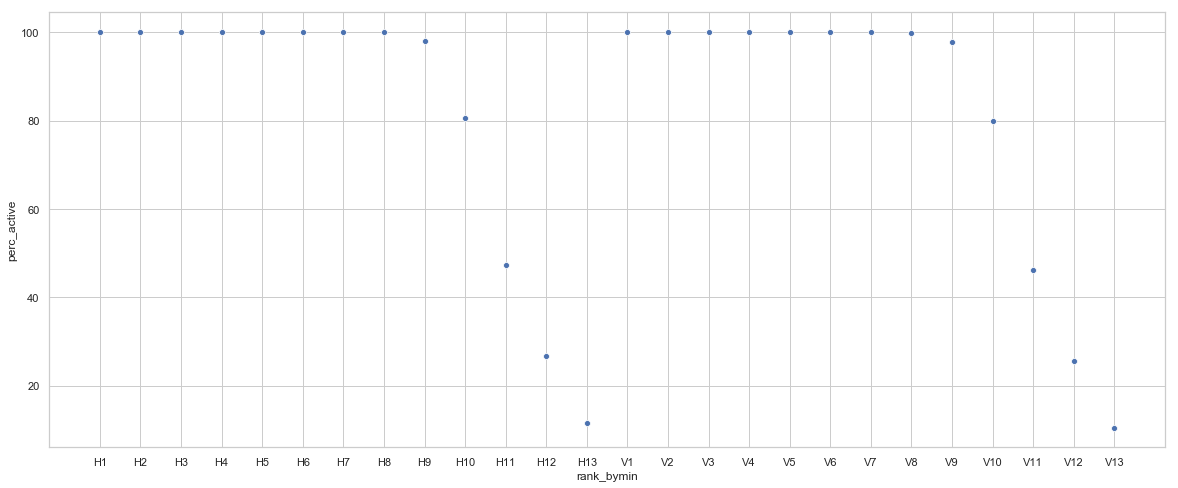

In [17]:
#bar plot showing count of active players, grouped by min_rank and h/v
plt.figure(figsize=(20,8))
g = sns.scatterplot(x='rank_bymin', y='perc_active', data=active_players_minrank)
plt.show()

# slightly lower percent of active players on away teams, which might reflect teams economizing by bringing
# fewer players to away games

### 3.3 Stitch together

In [21]:
h_data_frames = [train_dfs['H1'],
               train_dfs['H2'],
               train_dfs['H3'],
               train_dfs['H4'],
               train_dfs['H5'],
               train_dfs['H6'],
               train_dfs['H7'],
               train_dfs['H8'],
               train_dfs['H9'],
               train_dfs['H10'],
               train_dfs['H11'],
               train_dfs['H12'],
               train_dfs['H13']]

v_data_frames =[train_dfs['V1'],
               train_dfs['V2'],
               train_dfs['V3'],
               train_dfs['V4'],
               train_dfs['V5'],
               train_dfs['V6'],
               train_dfs['V7'],
               train_dfs['V8'],
               train_dfs['V9'],
               train_dfs['V10'],
               train_dfs['V11'],
               train_dfs['V12'],
               train_dfs['V13']]

join_cols = ['SEASON_YEAR',
             'GAME_DATE',
             'GAME_ID']

# left join to maintain correct count of games. In other words, if there aren't any active players past 7th, left join
# fills in nulls for those columns
h_train_data = reduce(lambda left,right: pd.merge(left, right, on = game_cols, how='left'), h_data_frames)
v_train_data = reduce(lambda left,right: pd.merge(left, right, on = game_cols, how='left'), v_data_frames)

train_data = h_train_data.merge(v_train_data, on = join_cols, how = 'inner')

train_data = train_data.rename(columns={'TEAM_ID_x' : 'TEAM_ID_H',
                                        'TEAM_ABBREVIATION_x' : 'TEAM_ABBREVIATION_H',
                                        'TEAM_CITY_x' : 'TEAM_CITY_H',
                                        'TEAM_PTS_x' : 'TEAM_PTS_H',
                                        'TEAM_ID_y' : 'TEAM_ID_V',
                                        'TEAM_ABBREVIATION_y' : 'TEAM_ABBREVIATION_V',
                                        'TEAM_CITY_y' : 'TEAM_CITY_V',
                                        'TEAM_PTS_y' : 'TEAM_PTS_V'
                                       })

train_data['HOME_WIN'] =  np.where(train_data['TEAM_PTS_H'] > train_data['TEAM_PTS_V'], 1, 0)


In [22]:
# replaced nulls with 0
train_data.fillna(0, inplace = True)

train_data.shape
train_data.head()


(2460, 974)

SEASON_YEAR   GAME_DATE   GAME_ID   TEAM_ID_H TEAM_ABBREVIATION_H  \
0     2017-18  2018-04-11  21701229  1610612757                 POR   
1     2017-18  2018-04-11  21701228  1610612746                 LAC   
2     2017-18  2018-04-11  21701222  1610612753                 ORL   
3     2017-18  2018-04-11  21701227  1610612760                 OKC   
4     2017-18  2018-04-11  21701219  1610612738                 BOS   

     TEAM_CITY_H  TEAM_PTS_H     MIN_H1  FGM_H1  FGA_H1  FG_PCT_H1  FG3M_H1  \
0       Portland         102  35.705667    8.40   19.12    0.43760     2.30   
1             LA         100  33.675667    7.20   15.72    0.45802     2.08   
2        Orlando         101  28.502667    6.68   14.28    0.44196     1.00   
3  Oklahoma City         137  36.360667   10.48   21.64    0.48412     0.94   
4         Boston         110  18.574000    2.52    5.50    0.43136     0.06   

   FG3A_H1  FG3_PCT_H1  FTM_H1  FTA_H1  FT_PCT_H1  OREB_H1  DREB_H1  REB_H1  \
0     6.02     0.36020    2.54    3.12    0.58762     0.68     3.26    3.94   
1     5.26     0.37696    2.44    3.06    0.59698     0.60     4.88    5.48   
2     3.36     0.24408    1.34    1.60    0.41550     1.84     7.24    9.08   
3     3.24     0.29142    5.32    7.00    0.75814     1.98     8.16   10.14   
4     0.30     0.03000    0.56    0.70    0.28000     1.30     3.92    5.22   

   AST_H1  STL_H1  BLK_H1  TO_H1  PF_H1  PTS_H1  PLUS_MINUS_H1  \
0    3.64    0.94    0.48   1.82   1.84   21.64           1.78   
1    2.84    1.02    0.58   1.50   2.12   18.92          -1.68   
2    3.30    1.00    1.04   1.90   2.50   15.70          -2.50   
3   10.26    1.74    0.34   4.78   2.46   27.22           5.72   
4    1.30    0.24    0.64   0.96   2.64    5.66           1.48   

   E_OFF_RATING_H1  OFF_RATING_H1  E_DEF_RATING_H1  DEF_RATING_H1  \
0          108.086        108.678          106.360        106.926   
1          106.826        108.058          109.668        110.910   
2           99.296         99.322          105.494        105.536   
3          113.170        115.100          105.666        107.032   
4          104.076        101.810          101.442        101.346   

   E_NET_RATING_H1  NET_RATING_H1  AST_PCT_H1  AST_TOV_H1  AST_RATIO_H1  \
0            1.722          1.750     0.16920      1.7246        13.856   
1           -2.850         -2.848     0.13272      1.3002        13.198   
2           -6.190         -6.212     0.18148      1.3666        15.782   
3            7.506          8.058     0.45918      2.9532        26.140   
4            2.624          0.464     0.10404      0.6734        15.238   

   TM_TOV_PCT_H1  EFG_PCT_H1  TS_PCT_H1  USG_PCT_H1  E_USG_PCT_H1  E_PACE_H1  \
0          6.982     0.49760    0.52384     0.26562       0.27122    99.2160   
1          6.976     0.52546    0.55364     0.23692       0.24164   100.6516   
2          9.374     0.47576    0.49760     0.24122       0.24638    97.5430   
3         12.092     0.50520    0.55016     0.32820       0.33316   102.1940   
4         12.082     0.43478    0.47316     0.16158       0.16924    97.6180   

    PACE_H1   PIE_H1     MIN_H2  FGM_H2  FGA_H2  FG_PCT_H2  FG3M_H2  FG3A_H2  \
0   98.6738  0.10796  34.924667    8.24   18.50    0.42700     3.22     8.64   
1   99.4928  0.10996  30.878333    5.42   12.16    0.39198     2.04     5.44   
2   97.4332  0.12768  27.049333    3.82    9.10    0.40342     1.52     4.50   
3  100.6786  0.19774  36.293333    7.42   16.90    0.43448     3.04     7.76   
4   98.6122  0.05990  18.574000    2.52    5.50    0.43136     0.06     0.30   

   FG3_PCT_H2  FTM_H2  FTA_H2  FT_PCT_H2  OREB_H2  DREB_H2  REB_H2  AST_H2  \
0     0.34024    6.48    7.12    0.83848     0.72     3.28    4.00    6.38   
1     0.30792    1.54    2.40    0.38312     0.38     1.94    2.32    3.94   
2     0.29600    0.98    1.24    0.36134     0.28     2.54    2.82    1.64   
3     0.37898    4.86    5.84    0.78618     0.92     4.74    5.66    3.46   
4     0.03

In [23]:
# reorganize columns
game_attrib_cols = list(train_data)[0:7] + list(train_data)[488:492] + ['HOME_WIN']


home_data_cols = list(train_data)[7:488]
visitor_data_cols = list(train_data)[492:-1]

train_data = train_data[game_attrib_cols + home_data_cols + visitor_data_cols]

train_data.to_csv(DATA_DIR/ 'train_data_16-18.csv')

In [24]:
train_data.tail()

SEASON_YEAR   GAME_DATE   GAME_ID   TEAM_ID_H TEAM_ABBREVIATION_H  \
2455     2016-17  2017-02-26  21600874  1610612747                 LAL   
2456     2016-17  2017-02-14  21600833  1610612747                 LAL   
2457     2016-17  2017-01-31  21600729  1610612747                 LAL   
2458     2016-17  2017-01-01  21600509  1610612748                 MIA   
2459     2016-17  2016-11-25  21600235  1610612743                 DEN   

      TEAM_CITY_H  TEAM_PTS_H   TEAM_ID_V TEAM_ABBREVIATION_V    TEAM_CITY_V  \
2455  Los Angeles          98  1610612759                 SAS    San Antonio   
2456  Los Angeles          96  1610612758                 SAC     Sacramento   
2457  Los Angeles         120  1610612743                 DEN         Denver   
2458        Miami          98  1610612765                 DET        Detroit   
2459       Denver         129  1610612760                 OKC  Oklahoma City   

      TEAM_PTS_V  HOME_WIN     MIN_H1    FGM_H1    FGA_H1  FG_PCT_H1  \
2455         119         0  29.026667  2.960000  8.180000   0.360240   
2456          97         0  28.718000  2.940000  8.000000   0.366720   
2457         116         1  27.876667  2.780000  7.760000   0.365740   
2458         107         0  22.293840  1.879818  4.691554   0.335464   
2459         132         0  20.621942  3.424603  8.387775   0.342451   

       FG3M_H1   FG3A_H1  FG3_PCT_H1    FTM_H1    FTA_H1  FT_PCT_H1   OREB_H1  \
2455  0.760000  2.440000    0.231640  1.680000  2.640000   0.468680  0.760000   
2456  0.760000  2.380000    0.237640  1.680000  2.580000   0.459020  0.720000   
2457  0.660000  2.320000    0.234640  1.760000  2.620000   0.448800  0.700000   
2458  0.726857  2.239415    0.247423  0.622139  0.859164   0.209400  1.273562   
2459  1.715001  3.836220    0.341301  1.048429  1.316920   0.479937  0.535916   

       DREB_H1    REB_H1    AST_H1    STL_H1    BLK_H1     TO_H1     PF_H1  \
2455  3.420000  4.180000  2.100000  0.440000  0.460000  1.300000  2.000000   
2456  3.460000  4.180000  2.020000  0.440000  0.480000  1.300000  2.020000   
2457  3.340000  4.040000  2.000000  0.460000  0.420000  1.300000  1.880000   
2458  1.734159  3.007721  1.286812  0.611685  0.236715  0.621846  1.667343   
2459  1.855973  2.391889  2.127401  0.275561  0.205314  1.360289  1.522313   

        PTS_H1  PLUS_MINUS_H1  E_OFF_RATING_H1  OFF_RATING_H1  \
2455  8.360000      -5.820000       104.950000     104.836000   
2456  8.320000      -4.400000       105.290000     105.224000   
2457  7.980000      -3.880000       104.852000     104.822000   
2458  5.108633      -0.695313        91.258545      91.345141   
2459  9.612636       0.979003       104.734318     103.767497   

      E_DEF_RATING_H1  DEF_RATING_H1  E_NET_RATING_H1  NET_RATING_H1  \
2455       113.852000     112.892000        -8.906000      -8.050000   
2456       112.058000     111.330000        -6.772000      -6.100000   
2457       110.520000     110.144000        -5.676000      -5.314000   
2458        92.468642      91.895661        -1.204375      -0.564817   
2459       106.593904     103.265510        -1.872071       0.514463   

      AST_PCT_H1  AST_TOV_H1  AST_RATIO_H1  TM_TOV_PCT_H1  EFG_PCT_H1  \
2455    0.101000    1.023200     15.712000       9.834000    0.404220   
2456    0.098880    0.983200     15.542000      10.014000    0.411860   
2457    0.099840    1.009800     15.974000      10.416000    0.410540   
2458    0.075334    0.532367     17.595124       5.536237    0.404419   
2459    0.157980    0.930179     18.014333       8.860519    0.425980   

      TS_PCT_H1  USG_PCT_H1  E_USG_PCT_H1   E_PACE_H1     PACE_H1    PIE_H1  \
2455   0.442400    0.153340      0.156840   99.867000  100.328200  0.045260   
2456   0.450160    0.152240      0.155820   99.763400  100.078800  0.047600   
2457   0.451360    0.155460      0.158900  100.034600  100.184000  0.047020   
2458   0.416956    0.096398      0.097856   85.042737   84.694055  0.053640   
2459   0.456466    0.190996     

## Outdated Code

In [ ]:
# found that any player with non-null in comment col did not play, so filter out of training data
pre_transp_train = player_stats_3_seasons.loc[(player_stats_3_seasons['COMMENT'].isna())]

# drop *reb_pct cols
pre_transp_train.drop(pre_transp_train.columns[39:42], axis = 1, inplace = True)
pre_transp_train.head()

#cols 0 - 9 are keys/identifiers. Only cols 10 - end will be used as training data
pre_transp_train.shape
#pre_transp_train.isnull().sum()